In [1]:
import numpy
import pandas
import scipy.signal

from matplotlib import pyplot as plt

## Example problem

We use as an example a system which we model as having 3 distinct states:

- s1 (low values)
- s2 (medium values)
- s3 (high values)

And we want that when going from low to high, the values will go through medium state.
But when moving from high to low, the medium state shall not be included.

For this example we will use a toy synthetic dataset.

The approach shown should work just as well for other HMMs, be it multi-variate GMMs, Poission emissions, discrete

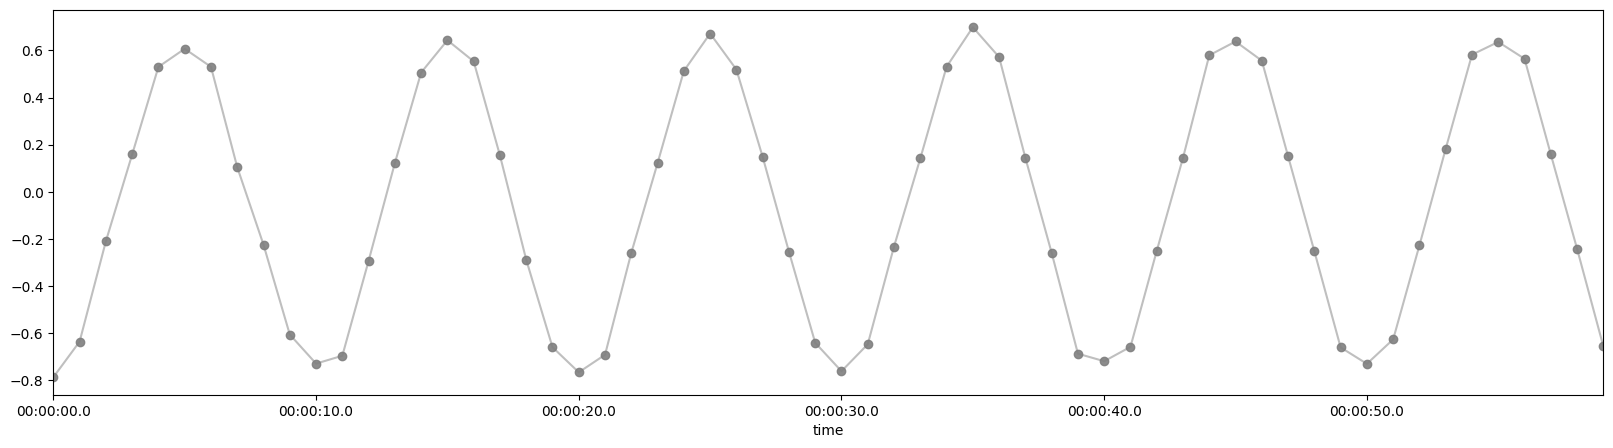

In [66]:

def sinewave(freq, duration, samplerate):
    sin = numpy.sin(2*numpy.pi*(freq/samplerate)*t)
    return sin, t

def triangle(freq, duration, samplerate, phase=0.5):

    t = numpy.arange(samplerate*duration)
    triangle = scipy.signal.sawtooth(2*numpy.pi*freq*(t/samplerate), phase)

    clipped = numpy.clip(triangle, -0.7, 0.7)
    
    return clipped, t
    
def make_series(shape='triangle', period='10sec', freq='1sec', duration='1min'):
    period = pandas.Timedelta(period)
    duration = pandas.Timedelta(duration)
    freq = pandas.Timedelta(freq)
    
    if shape == 'sine':
        w = sinewave(1/period.total_seconds(), duration.total_seconds(), freq.total_seconds())
    elif shape == 'triangle':
        w = triangle(1/period.total_seconds(), duration.total_seconds(), freq.total_seconds())
    else:
        raise ValueError(f"Unknown shape '{shape}'")
    y, t = w
    y = y + (-.1 * numpy.random.random(size=len(y)) )
    #y = 0
    t = pandas.to_timedelta(t, unit='s')
    s = pandas.Series(y, index=t)
    s.index.name = 'time'
    return s

def plot_data(X, states=None, title=''):
    fig, ax = plt.subplots(1, figsize=(20, 5))
    fig.suptitle(title)

    # Plot data
    X.plot(ax=ax, marker='o', ls='none', color='grey', alpha=0.9)
    X.plot(ax=ax, ls='-', alpha=0.5, color='grey')

    # Plot states
    # FIXME: use one color per state
    if states is not None:
        ax2 = ax.twinx()
        n_states = len(numpy.unique(states))
        for s_no in range(n_states):
            sub = states[states == s_no]
            sub.plot(ax=ax2,ls='none', marker='o', ms=5, label=f's{s_no}')
        ax2.legend()
            
X = make_series(period='10sec')
plot_data(X)

## hmmlearn implementation

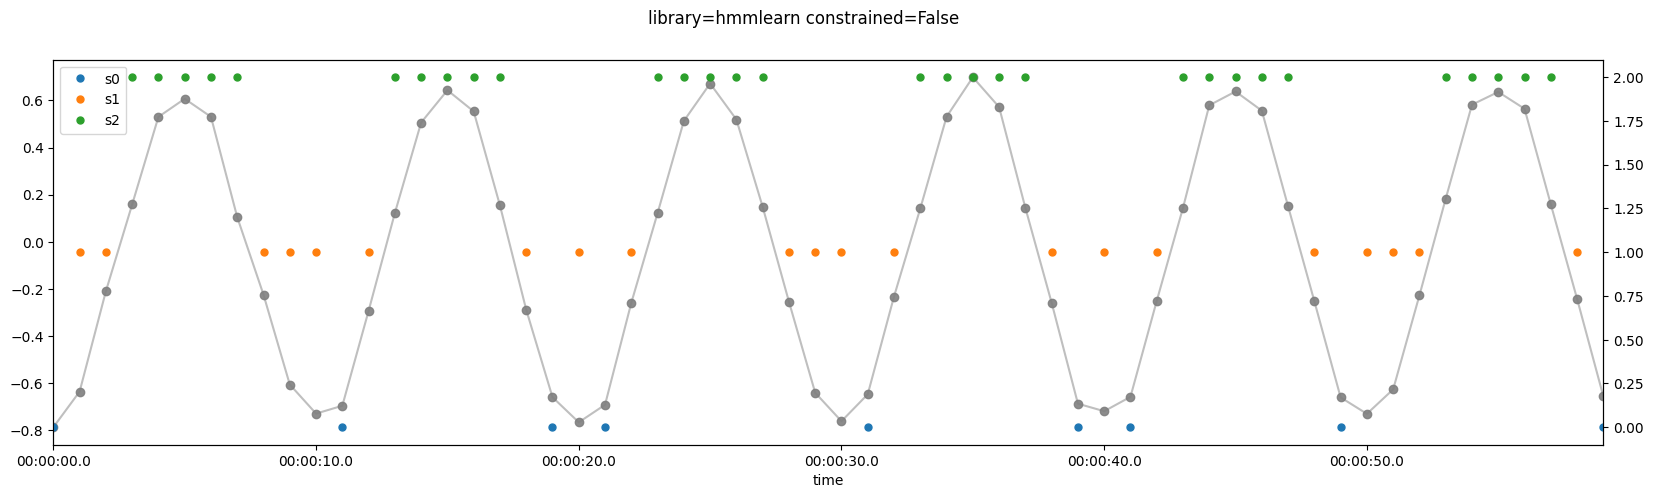

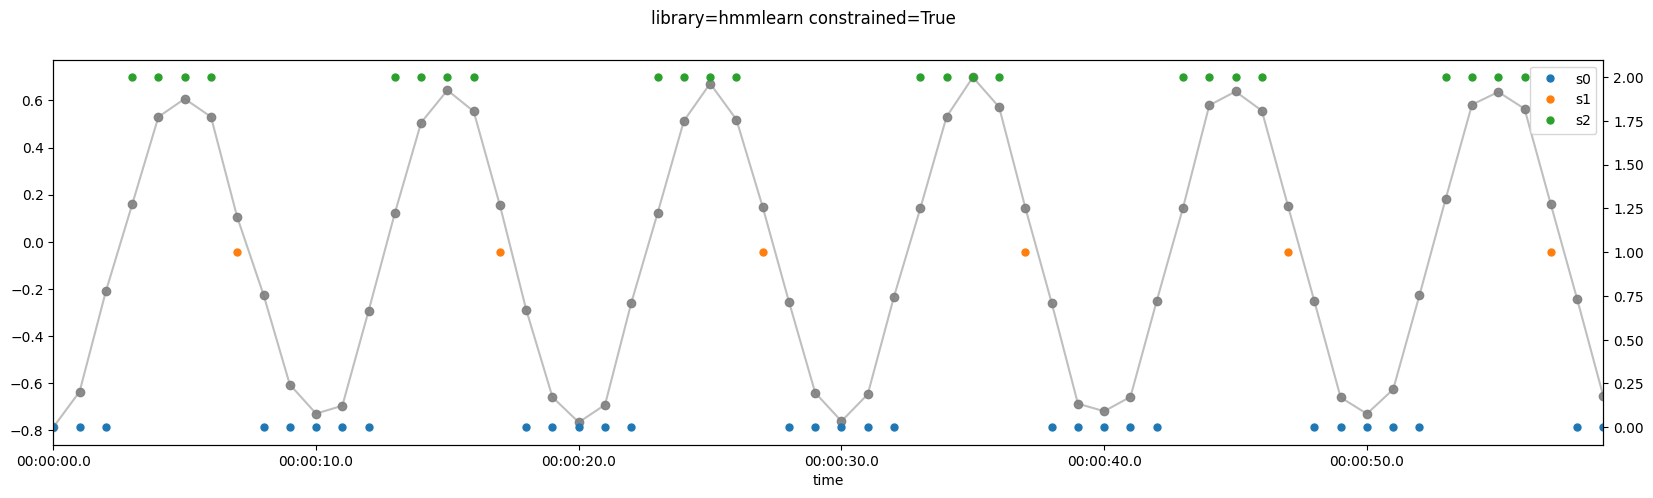

In [67]:
import hmmlearn.hmm

class ConstrainedGaussianHMM(hmmlearn.hmm.GaussianHMM):
    def _do_mstep(self, stats):
        
        # do the standard HMM learning step
        super()._do_mstep(stats)
        
        # find which states are where
        # we name them based on their typical value
        m = numpy.squeeze(self.means_)
        s = numpy.argsort(m)
        s1, s2, s3 = s
        
        # constrain the transition matrix
        # disallow s1->s2 and/or s2->s3 is not allowed
        self.transmat_[s1,s2] = 0.0
        self.transmat_[s2,s3] = 0.0


def format_sequence_hmmlearn(s):
    return s.values.reshape(-1, 1)

def test_hmmlearn_model(X, constrain):
    
    # Chose model
    if constrain:
        Model = ConstrainedGaussianHMM
    else:
        Model = hmmlearn.hmm.GaussianHMM

    model = Model(n_components=3, covariance_type='diag')
    model.fit(format_sequence_hmmlearn(X))

    # sort states based on their value
    mapping = numpy.argsort(numpy.squeeze(model.means_))
    inv_mapping = numpy.argsort(mapping)

    # Estimate states
    scores = model.score_samples(format_sequence_hmmlearn(X))[1]
    states = inv_mapping[numpy.argmax(scores, axis=1)]
    states = pandas.Series(states, index=X.index)
    
    # Visualize data and results
    plot_data(X, states=states, title=f'library=hmmlearn constrained={constrain}')

test_hmmlearn_model(X, constrain=False)
test_hmmlearn_model(X, constrain=True)
    
#print(states)

## Pomegranate implementation

build edges 3 tensor([[-2.3026,  0.0000,  0.0000],
        [ 0.0000, -2.3026,  0.0000],
        [ 0.0000,  0.0000, -2.3026]])
(1, 60, 1) 3
[1] Improvement: 36.604652404785156, Time: 0.00488s
[2] Improvement: 8.534463882446289, Time: 0.005526s
[3] Improvement: 3.5730295181274414, Time: 0.004296s
[4] Improvement: 5.212749481201172, Time: 0.005028s
[5] Improvement: 14.373172760009766, Time: 0.004274s
[6] Improvement: 5.636664390563965, Time: 0.004669s
[7] Improvement: 0.014665603637695312, Time: 0.005337s
fitted edges torch.Size([3, 3]) 
 tensor([[ -0.4057,  -1.0983, -29.3098],
        [ -0.6931,     -inf,  -0.6934],
        [-30.4922,  -1.6094,  -0.2657]])
torch.Size([60, 3])
build edges 3 tensor([[ -2.3026, -16.1181,   0.0000],
        [  0.0000,  -2.3026, -16.1181],
        [  0.0000,   0.0000,  -2.3026]])
(1, 60, 1) 3
[1] Improvement: 69.06700897216797, Time: 0.004834s
[2] Improvement: 5.810976028442383, Time: 0.003553s
[3] Improvement: 0.5811767578125, Time: 0.003565s
[4] Improvement

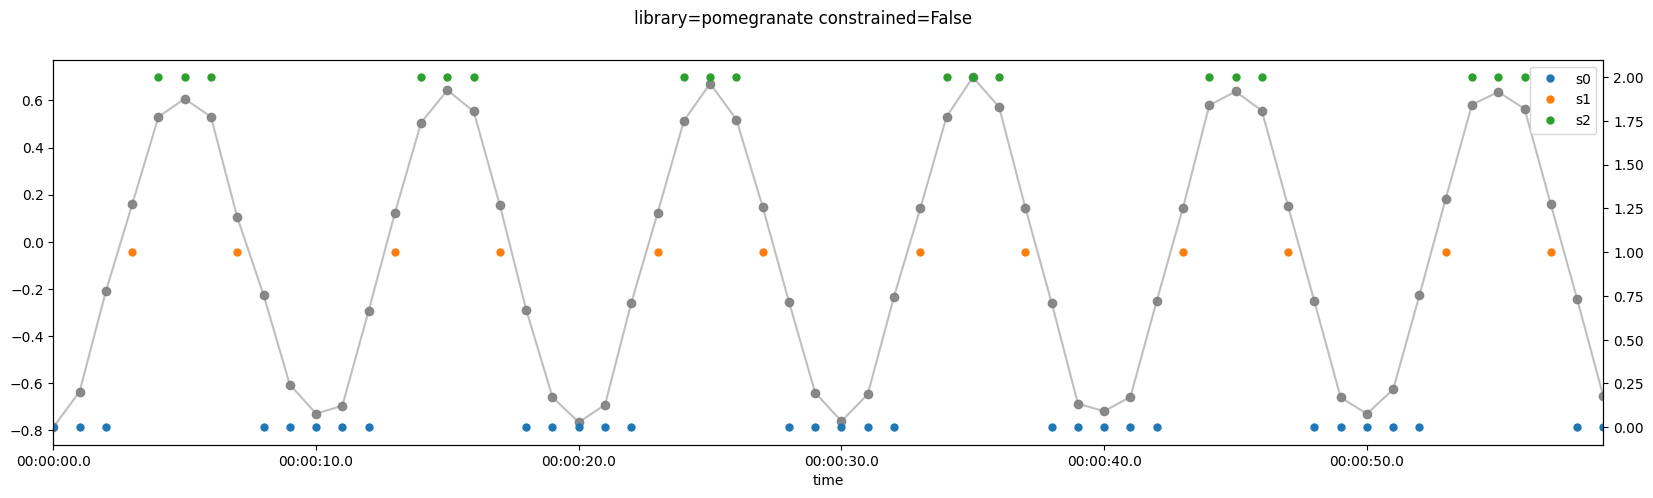

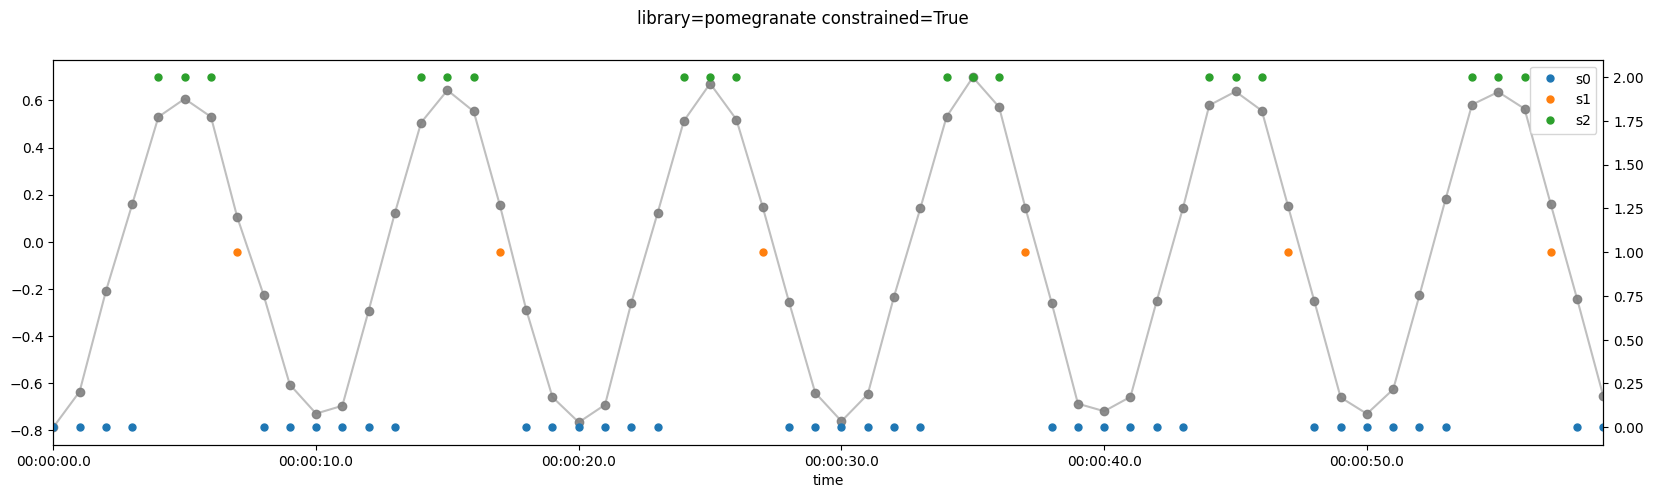

In [103]:
def get_parameters(model):
    parameters = dict(
        name = [],
        mean = [],
        #std = [],
    )
    
    for s in model.distributions:
        assert len(s.means) == 1
        #mean, std = s.distribution.parameters
        mean = float(s.means[0])
        parameters['mean'].append(mean)
        #parameters['std'].append(std)
        parameters['name'].append(s.name)

    
    df = pandas.DataFrame(parameters).set_index('name')
    return df


import pomegranate



def build_pomegranate_hmm(constrain):
    from pomegranate.hmm import SparseHMM, DenseHMM
    from pomegranate.distributions import Normal, Categorical
    
    s1 = Normal()
    s1.name = 's1'
    s2 = Normal()
    s2.name = 's2'
    s3 = Normal()
    s3.name = 's3'
    states = [s1, s2, s3]

    # FIXME: use SparseHMM instead? Just gives NaNs when fittin
    # NOTE: inertia must be set to non-zero value, because the default of 0.0 will ignore provided edge probabilities
    model = DenseHMM(verbose=True, max_iter=30, inertia=0.1)
    model.add_distributions([s1, s2, s3])
    #model.add_states(states)

    # if contrained, then s1->s2 and/or s2->s3 is not allowed
    model.add_edge(s1, s2, 0.0000001 if constrain else 1.0)
    model.add_edge(s2, s3, 0.0000001 if constrain else 1.0)
        
    model.add_edge(s3, s1, 1.0)
    model.add_edge(s1, s3, 1.0)
    model.add_edge(s3, s2, 1.0)
    model.add_edge(s2, s1, 1.0)

    # self transitions
    for s in states:
        model.add_edge(s, s, 0.1)
    
    # start/end
    for s in states:
        #model.add_edge(model.start, s, 1.0)
        #model.add_edge(model.end, s, 1.0)
        pass
    

    print('build edges', len(model.edges), model.edges)
    
    return model
        
        
def test_pomegranate_model(X, constrain):
    import functools
    import torch

    #tensor = torch.from_numpy(numpy.expand_dims(X.values, 1))
    tensor = numpy.expand_dims(numpy.expand_dims(X.values, -1), 0)
    #tensor = torch.randn(100, 50, 1)
    
    # Chose model
    model = build_pomegranate_hmm(constrain=constrain)

    # Estimate states
    print(tensor.shape, len(tensor.shape))


    model.fit(X=tensor)

    #model.plot() # XXX: when enabled, messes up the other plots!?!?
    print('fitted edges', model.edges.shape, '\n', model.edges)
    
    # sort states based on their value
    means = get_parameters(model).reset_index()['mean']
    #print('distribution means', means)

    mapping = numpy.argsort(means)
    inv_mapping = numpy.argsort(mapping)
    
    scores = model.predict_proba(X=tensor)[0]
    print(scores.shape)
    c  = numpy.argmax(scores, axis=1)
    #state_values = means[list(c)].values
    states = inv_mapping[list(c)].values
    states = pandas.Series(states, index=X.index)

    # Visualize data and results
    plot_data(X, states=states, title=f'library=pomegranate constrained={constrain}')
    

test_pomegranate_model(X, constrain=False)
m = test_pomegranate_model(X, constrain=True)
m